<a href="https://colab.research.google.com/github/Yaakov-Sternberg/USD-Capstone-Project-to-Predict-Preterm-Infant-Bradycardia-Events-/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb --quiet
import os
import glob

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = "/content/picsdb_local/physionet.org/files/picsdb/1.0.0"
INFANT_IDS = [f"infant{i}" for i in range(1, 11)]

plt.style.use("ggplot")
sns.set_palette("husl")

def check_directories():
    """Verify that the dataset directory exists."""
    if not os.path.exists(DATA_DIR):
        print(f"ERROR: Directory not found: {DATA_DIR}")
        return False
    print(f"Data directory located: {DATA_DIR}")
    print(f"Infant IDs to process: {INFANT_IDS}")
    return True


def discover_records():
    """Auto-discover ECG and Resp records from the directory.

    Returns
    -------
    ecg_records : list of str
    resp_records : list of str
    """
    ecg_records, resp_records = [], []
    for f in os.listdir(DATA_DIR):
        if f.endswith("_ecg.hea"):
            ecg_records.append(f.replace(".hea", ""))
        elif f.endswith("_resp.hea"):
            resp_records.append(f.replace(".hea", ""))
    ecg_records = sorted(ecg_records)
    resp_records = sorted(resp_records)
    print("\nDiscovered ECG records:", ecg_records)
    print("Discovered Respiration records:", resp_records)
    return ecg_records, resp_records

# Variables

In [ ]:
# Variable Discovery
def get_signal_metadata_for_infant(infant_id):
    """Parse ECG and Resp headers for a given infant.

    Returns a dict with fields like fs, length, units, channel names, and errors if any.
    """
    meta = {"infant": infant_id}

    # ECG header
    try:
        ecg_header = wfdb.rdheader(os.path.join(DATA_DIR, f"{infant_id}_ecg"))
        meta["ecg_fs"] = ecg_header.fs
        meta["ecg_len"] = ecg_header.sig_len
        meta["ecg_units"] = ecg_header.units
        meta["ecg_channels"] = ecg_header.sig_name
    except Exception as e:
        meta["ecg_error"] = str(e)

    # Resp header
    try:
        resp_header = wfdb.rdheader(os.path.join(DATA_DIR, f"{infant_id}_resp"))
        meta["resp_fs"] = resp_header.fs
        meta["resp_len"] = resp_header.sig_len
        meta["resp_units"] = resp_header.units
        meta["resp_channels"] = resp_header.sig_name
    except Exception as e:
        meta["resp_error"] = str(e)

    return meta


def analyze_metadata():
    """Summarize variables/signals and basic metadata across all infants."""
    print("\n=== 1. Variable & Metadata Analysis ===")
    rows = []
    for infant in INFANT_IDS:
        rows.append(get_signal_metadata_for_infant(infant))

    df_meta = pd.DataFrame(rows)
    display(df_meta)

    # Unique signal/channel names across ECG and Resp
    all_channels = set()
    if "ecg_channels" in df_meta:
        for ch_list in df_meta["ecg_channels"].dropna():
            all_channels.update(ch_list)
    if "resp_channels" in df_meta:
        for ch_list in df_meta["resp_channels"].dropna():
            all_channels.update(ch_list)

    print("\nUnique variables (signal channels) found:", all_channels)
    print("ECG sampling frequencies:", df_meta.get("ecg_fs", pd.Series()).dropna().unique())
    print("Resp sampling frequencies:", df_meta.get("resp_fs", pd.Series()).dropna().unique())

    # Useful subset of metadata to glance at
    cols_to_show = [c for c in [
        "infant", "ecg_len", "resp_len", "ecg_channels", "resp_channels", "ecg_units", "resp_units"
    ] if c in df_meta.columns]
    print("\nPer-infant signal overview:")
    display(df_meta[cols_to_show])

    return df_meta

# Check Wheather Cleaning is Needed

In [ ]:
# Structural & Signal-level Data Issues
def analyze_structural_integrity(ecg_records, resp_records):
    """Check for missing companion files and inconsistent sampling rates."""
    print("\n=== 2A. Structural Dataset Integrity ===")
    issues = []

    # ECG companions: .dat, .hea, .atr, .qrsc
    for rec in ecg_records:
        base = os.path.join(DATA_DIR, rec)
        required = [f"{rec}.dat", f"{rec}.hea", f"{rec}.atr", f"{rec}.qrsc"]
        for req in required:
            if not os.path.isfile(os.path.join(DATA_DIR, req)):
                issues.append(f"Missing ECG companion file: {req}")

    # Resp companions: .dat, .hea, .resp
    for rec in resp_records:
        required = [f"{rec}.dat", f"{rec}.hea", f"{rec}.resp"]
        for req in required:
            if not os.path.isfile(os.path.join(DATA_DIR, req)):
                issues.append(f"Missing Resp companion file: {req}")

    # Header-level checks
    meta_rows = []
    for rec in ecg_records + resp_records:
        info = {"record": rec}
        try:
            header = wfdb.rdheader(os.path.join(DATA_DIR, rec))
            info["fs"] = header.fs
            info["sig_len"] = header.sig_len
            info["n_sig"] = header.n_sig
            info["units"] = header.units
            info["error"] = None
        except Exception as e:
            info["error"] = str(e)
        meta_rows.append(info)

    df_struct = pd.DataFrame(meta_rows)
    display(df_struct)

    # Sampling rate consistency
    if "fs" in df_struct:
        fs_values = df_struct["fs"].dropna().unique()
        if len(fs_values) > 1:
            issues.append(f"Inconsistent sampling rates found: {fs_values}")

    # Header-read errors
    err_rows = df_struct[df_struct["error"].notna()]
    if len(err_rows) > 0:
        issues.append("Some headers could not be read. See df_struct for details.")

    if issues:
        print("\nStructural issues detected:")
        for i in issues:
            print(" -", i)
    else:
        print("\nNo major structural issues detected.")

    return df_struct, issues


def check_data_quality(infant_id, window_seconds=10, flat_std_threshold=0.001):
    """Check a mid-record ECG slice for NaNs and flatline behavior.

    To avoid huge memory use, only a short slice from the middle of the recording is loaded.
    """
    issues = {"infant": infant_id, "nans": 0, "flatline": False, "error": None}

    try:
        header = wfdb.rdheader(os.path.join(DATA_DIR, f"{infant_id}_ecg"))
        if header.sig_len is None or header.sig_len == 0:
            issues["error"] = "Empty or unknown ECG length"
            return issues

        mid_point = header.sig_len // 2
        # 250 Hz * window_seconds
        window_samples = int(250 * window_seconds)

        record = wfdb.rdrecord(
            os.path.join(DATA_DIR, f"{infant_id}_ecg"),
            sampfrom=max(0, mid_point),
            sampto=min(header.sig_len, mid_point + window_samples),
        )
        sig = record.p_signal

        if np.isnan(sig).any():
            issues["nans"] += 1

        if np.std(sig) < flat_std_threshold:
            issues["flatline"] = True

    except Exception as e:
        issues["error"] = str(e)

    return issues


def analyze_quality():
    """Run signal-level data-quality checks across all infants."""
    print("\n=== 2B. Signal-Level Quality Check (sampled) ===")
    quality_reports = [check_data_quality(infant) for infant in INFANT_IDS]
    df_qual = pd.DataFrame(quality_reports)
    display(df_qual)
    return df_qual

# Bradycardia-related Patterns

In [ ]:
# Bradycardia-related Patterns
def analyze_heart_rate_patterns(infant_id):
    """Derive instantaneous heart rate from .qrsc annotations.

    Returns
    -------
    clean_hr : np.ndarray or None
        Filtered HR series (BPM) within physiological ranges.
    hr_samples : np.ndarray or None
        Sample indices corresponding to each HR value.
    """
    try:
        ann = wfdb.rdann(os.path.join(DATA_DIR, f"{infant_id}_ecg"), "qrsc")

        # RR intervals in seconds (fs=250Hz)
        rr_intervals = np.diff(ann.sample) / 250.0
        hr_bpm = 60.0 / rr_intervals

        # Filter artifacts: very low / high HR
        clean_mask = (hr_bpm > 40) & (hr_bpm < 250)
        clean_hr = hr_bpm[clean_mask]
        hr_samples = ann.sample[1:][clean_mask]

        return clean_hr, hr_samples

    except Exception as e:
        print(f"Could not process HR for {infant_id}: {e}")
        return None, None


def plot_bradycardia_event(infant_id, brady_threshold=100.0):
    """Visualize a bradycardia event: ECG, respiration, and HR around lowest HR point."""
    print(f"\n=== 3. Bradycardia Pattern Visualization: {infant_id} ===")

    hr_bpm, hr_samples = analyze_heart_rate_patterns(infant_id)
    if hr_bpm is None or hr_samples is None or len(hr_bpm) == 0:
        print("No HR data available.")
        return

    low_hr_indices = np.where(hr_bpm < brady_threshold)[0]
    if len(low_hr_indices) == 0:
        print(f"No HR below {brady_threshold} BPM found for {infant_id}.")
        return

    # Most severe drop
    min_hr_idx = np.argmin(hr_bpm)
    event_sample = hr_samples[min_hr_idx]
    min_bpm = hr_bpm[min_hr_idx]
    print(f"Deepest bradycardia: {min_bpm:.2f} BPM at sample {event_sample}.")

    # Define a ±10 second window around the event (20 seconds total)
    # 250 Hz * 10 s = 2500 samples on each side
    window = 2500
    samp_from = max(0, int(event_sample - window))
    samp_to = int(event_sample + window)

    try:
        # Load ECG and Resp waveforms in that window
        ecg_record = wfdb.rdrecord(
            os.path.join(DATA_DIR, f"{infant_id}_ecg"),
            sampfrom=samp_from,
            sampto=samp_to,
        )
        resp_record = wfdb.rdrecord(
            os.path.join(DATA_DIR, f"{infant_id}_resp"),
            sampfrom=samp_from,
            sampto=samp_to,
        )
    except Exception as e:
        print(f"Error loading waveforms around event: {e}")
        return

    ecg_sig = ecg_record.p_signal[:, 0]
    resp_sig = resp_record.p_signal[:, 0]

    t = np.arange(samp_from, samp_to) / 250.0

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # ECG
    ax1.plot(t, ecg_sig, alpha=0.8)
    ax1.set_ylabel("ECG (mV)")
    ax1.set_title(f"Bradycardia Event (HR<{brady_threshold} BPM): {infant_id}")

    # Respiration
    ax2.plot(t, resp_sig, alpha=0.8)
    ax2.set_ylabel("Respiration")

    # HR in the same window
    mask = (hr_samples >= samp_from) & (hr_samples <= samp_to)
    ax3.plot(hr_samples[mask] / 250.0, hr_bpm[mask], "r-o", markersize=3)
    ax3.axhline(y=brady_threshold, color="k", linestyle="--", label=f"Brady Threshold ({brady_threshold} BPM)")
    ax3.set_ylabel("Heart Rate (BPM)")
    ax3.set_xlabel("Time (s)")
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Correlation Analysis

In [ ]:
# Variable Correlations
def compute_hr_from_qrsc(infant_id):
    """Convenience wrapper to compute HR for correlation analysis."""
    return analyze_heart_rate_patterns(infant_id)


def compute_resp_rate_from_annotations(infant_id):
    """Compute respiration rate (breaths per minute) from .resp annotations."""
    try:
        ann = wfdb.rdann(os.path.join(DATA_DIR, f"{infant_id}_resp"), "resp")
        timestamps = ann.sample / 250.0  # seconds
        if len(timestamps) < 2:
            return None, None
        intervals = np.diff(timestamps)  # seconds between events
        resp_rate = 60.0 / intervals     # breaths per minute
        # Use mid-interval timestamps for each rate value
        mid_times = (timestamps[:-1] + timestamps[1:]) / 2.0
        return resp_rate, mid_times
    except Exception as e:
        print(f"Could not process RespRate for {infant_id}: {e}")
        return None, None


def analyze_hr_resp_correlation(infants_for_corr=None):
    """Estimate correlation between heart rate and respiration rate across infants."""
    if infants_for_corr is None:
        infants_for_corr = INFANT_IDS

    print("\n=== 4A. HR vs Respiration Rate Correlation ===")

    hr_all = []
    resp_all = []

    for infant in infants_for_corr:
        hr_bpm, hr_samples = compute_hr_from_qrsc(infant)
        resp_rate, resp_times = compute_resp_rate_from_annotations(infant)

        if hr_bpm is None or resp_rate is None:
            continue

        # Very simple alignment: truncate to min length
        n = min(len(hr_bpm), len(resp_rate))
        if n == 0:
            continue

        hr_all.extend(hr_bpm[:n])
        resp_all.extend(resp_rate[:n])

    if len(hr_all) == 0 or len(resp_all) == 0:
        print("Insufficient HR/Resp data for correlation.")
        return None

    df_corr = pd.DataFrame({"HR_BPM": hr_all, "RespRate_BPM": resp_all}).dropna()
    print("Correlation matrix (HR vs RespRate):")
    display(df_corr.corr())

    # Quick scatter
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df_corr.sample(min(2000, len(df_corr))), x="HR_BPM", y="RespRate_BPM", alpha=0.4)
    plt.title("HR vs Respiration Rate (across infants)")
    plt.xlabel("Heart Rate (BPM)")
    plt.ylabel("Respiration Rate (breaths/min)")
    plt.tight_layout()
    plt.show()

    return df_corr


def analyze_raw_signal_correlation(infant_id, start_sample=100000, duration_seconds=60):
    """Analyze raw ECG vs Respiration signal correlation for a 1-minute segment."""
    print(f"\n=== 4B. Raw ECG vs Respiration Correlation: {infant_id} ===")

    duration_samples = int(250 * duration_seconds)

    try:
        ecg_record = wfdb.rdrecord(
            os.path.join(DATA_DIR, f"{infant_id}_ecg"),
            sampfrom=start_sample,
            sampto=start_sample + duration_samples,
        )
        resp_record = wfdb.rdrecord(
            os.path.join(DATA_DIR, f"{infant_id}_resp"),
            sampfrom=start_sample,
            sampto=start_sample + duration_samples,
        )
    except Exception as e:
        print(f"Error reading raw signals for correlation: {e}")
        return None

    ecg = ecg_record.p_signal.flatten()
    resp = resp_record.p_signal.flatten()

    df = pd.DataFrame({"ECG": ecg, "Respiration": resp})
    corr_val = df.corr().iloc[0, 1]
    print(f"Raw signal Pearson correlation: {corr_val:.4f}")

    # Scatter (sample for speed)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=df.sample(min(2000, len(df))), x="ECG", y="Respiration", alpha=0.3)
    plt.title(f"ECG vs Respiration (raw) - {infant_id}")
    plt.tight_layout()
    plt.show()

    return df

# Simple Signal Statistics

In [ ]:
# Simple Signal Statistics
def summarize_short_window_stats(records, seconds=10):
    """Compute simple stats (mean, std, range) for the first N seconds of each record."""
    print("\n=== 5. Short-Window Signal Statistics (example records) ===")
    stats_rows = []

    for rec in records:
        try:
            header = wfdb.rdheader(os.path.join(DATA_DIR, rec))
            fs = header.fs
            sampto = int(fs * seconds)
            record = wfdb.rdrecord(os.path.join(DATA_DIR, rec), sampfrom=0, sampto=sampto)
            sig = record.p_signal[:, 0]
            stats_rows.append({
                "record": rec,
                "mean": float(np.mean(sig)),
                "std": float(np.std(sig)),
                "min": float(np.min(sig)),
                "max": float(np.max(sig)),
                "range": float(np.max(sig) - np.min(sig)),
            })
        except Exception as e:
            stats_rows.append({"record": rec, "error": str(e)})

    df_stats = pd.DataFrame(stats_rows)
    display(df_stats)
    return df_stats


# Main

Data directory located: /content/picsdb_local/physionet.org/files/picsdb/1.0.0
Infant IDs to process: ['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']

Discovered ECG records: ['infant10_ecg', 'infant1_ecg', 'infant2_ecg', 'infant3_ecg', 'infant4_ecg', 'infant5_ecg', 'infant6_ecg', 'infant7_ecg', 'infant8_ecg', 'infant9_ecg']
Discovered Respiration records: ['infant10_resp', 'infant1_resp', 'infant2_resp', 'infant3_resp', 'infant4_resp', 'infant5_resp', 'infant6_resp', 'infant7_resp', 'infant8_resp', 'infant9_resp']

=== 1. Variable & Metadata Analysis ===


,infant,ecg_fs,ecg_len,ecg_units,ecg_channels,resp_fs,resp_len,resp_units,resp_channels
0,infant1,250,41052191,[mV],[ECG],500,82122000,[NU],[RESP]
1,infant2,500,78916000,[mV],[II],50,7891433,[NU],[RESP]
2,infant3,500,78684614,[mV],[II],50,7868296,[NU],[RESP]
3,infant4,500,84208000,[mV],[II],50,8420800,[NU],[RESP]
4,infant5,250,43878723,[mV],[ECG],50,8955598,[NU],[RESP]
5,infant6,500,87492197,[mV],[II],50,8749057,[NU],[RESP]
6,infant7,500,36604500,[mV],[II],50,3660288,[NU],[RESP]
7,infant8,500,44288000,[mV],[II],50,4428613,[NU],[RESP]
8,infant9,500,126569088,[mV],[II],50,12656784,[NU],[RESP]
9,infant10,500,85083254,[mV],[I],50,8508154,[NU],[RESP]



Unique variables (signal channels) found: {'RESP', 'ECG', 'II', 'I'}
ECG sampling frequencies: [250 500]
Resp sampling frequencies: [500  50]

Per-infant signal overview:


,infant,ecg_len,resp_len,ecg_channels,resp_channels,ecg_units,resp_units
0,infant1,41052191,82122000,[ECG],[RESP],[mV],[NU]
1,infant2,78916000,7891433,[II],[RESP],[mV],[NU]
2,infant3,78684614,7868296,[II],[RESP],[mV],[NU]
3,infant4,84208000,8420800,[II],[RESP],[mV],[NU]
4,infant5,43878723,8955598,[ECG],[RESP],[mV],[NU]
5,infant6,87492197,8749057,[II],[RESP],[mV],[NU]
6,infant7,36604500,3660288,[II],[RESP],[mV],[NU]
7,infant8,44288000,4428613,[II],[RESP],[mV],[NU]
8,infant9,126569088,12656784,[II],[RESP],[mV],[NU]
9,infant10,85083254,8508154,[I],[RESP],[mV],[NU]



=== 2A. Structural Dataset Integrity ===


,record,fs,sig_len,n_sig,units,error
0,infant10_ecg,500,85083254,1,[mV],None
1,infant1_ecg,250,41052191,1,[mV],None
2,infant2_ecg,500,78916000,1,[mV],None
3,infant3_ecg,500,78684614,1,[mV],None
4,infant4_ecg,500,84208000,1,[mV],None
5,infant5_ecg,250,43878723,1,[mV],None
6,infant6_ecg,500,87492197,1,[mV],None
7,infant7_ecg,500,36604500,1,[mV],None
8,infant8_ecg,500,44288000,1,[mV],None
9,infant9_ecg,500,126569088,1,[mV],None



Structural issues detected:
 - Inconsistent sampling rates found: [500 250  50]

=== 2B. Signal-Level Quality Check (sampled) ===


,infant,nans,flatline,error
0,infant1,0,False,None
1,infant2,0,False,None
2,infant3,0,False,None
3,infant4,0,False,None
4,infant5,0,False,None
5,infant6,0,False,None
6,infant7,0,False,None
7,infant8,0,False,None
8,infant9,0,False,None
9,infant10,0,False,None



=== 3. Bradycardia Pattern Visualization: infant1 ===
Deepest bradycardia: 41.10 BPM at sample 867205.


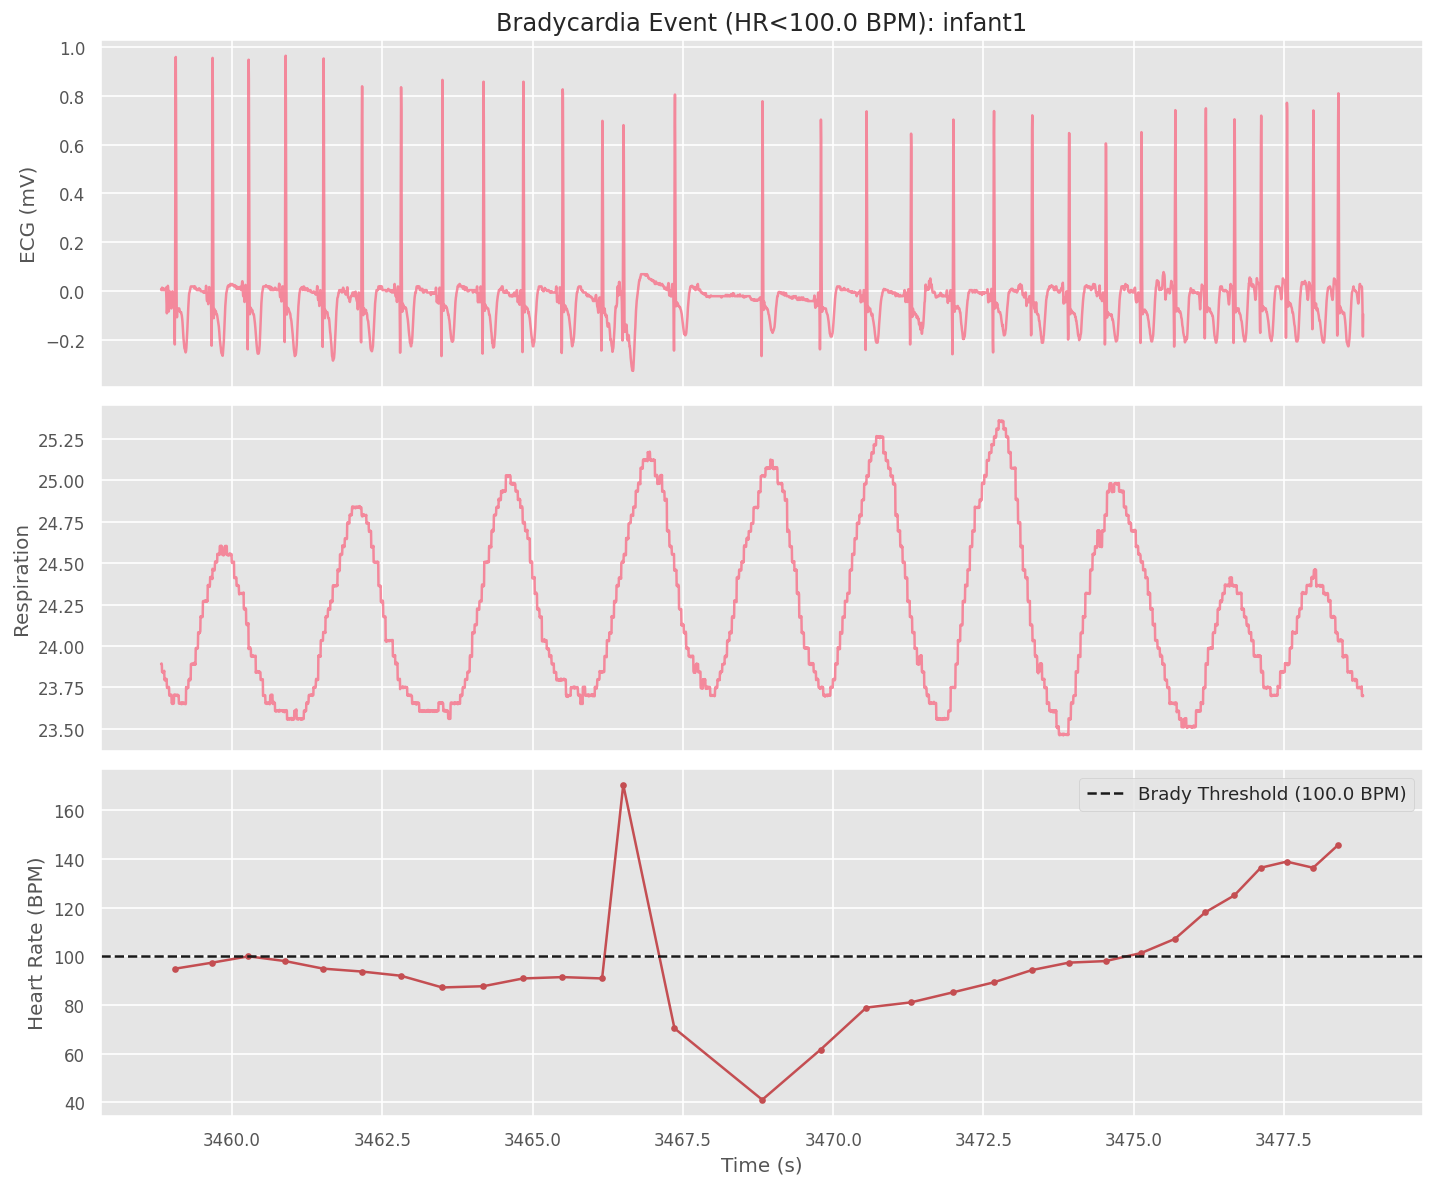


=== 3. Bradycardia Pattern Visualization: infant5 ===
Deepest bradycardia: 48.70 BPM at sample 29043965.
Error loading waveforms around event: sampfrom must be shorter than the signal length

=== 4A. HR vs Respiration Rate Correlation ===


In [ ]:


if __name__ == "__main__":
    if check_directories():
        # Discover records present on disk
        ecg_records, resp_records = discover_records()

        # Variables / metadata
        df_meta = analyze_metadata()

        # Structural & signal-level issues
        df_struct, struct_issues = analyze_structural_integrity(ecg_records, resp_records)
        df_qual = analyze_quality()

        # Bradycardia pattern visualization for a couple of example infants
        for subject in ["infant1", "infant5"]:
            plot_bradycardia_event(subject)

        # HR vs respiration rate correlation across infants
        analyze_hr_resp_correlation(infants_for_corr=["infant1", "infant2", "infant3", "infant4", "infant5"])

        # Raw signal correlation for example infants
        for subject in ["infant1", "infant5"]:
            analyze_raw_signal_correlation(subject)

        # Short-window stats for a few ECG records
        summarize_short_window_stats(ecg_records[:3])

#### I used the following LLMs:
* Gemini
* ChatGPT
* Codey (Google Colab AI code completion)

#### For the following general tasks:
* Autocomplete suggestions
* Debugging/error explainations
* Feedback & suggestions for improving code
* Improveing readability (refactoring, commenting, etc.)